In [17]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [18]:
%autoreload 2
%matplotlib inline
# import sys
# import os
# module_path = os.path.abspath(os.path.join('..'))
# sys.path.append(module_path)
# Stdlib
from itertools import chain
from time import time
from datetime import datetime, date, timedelta
from collections import namedtuple
from operator import attrgetter
# Fast array operations
import numpy as np
import pandas
from dataclasses import dataclass
# ML
from sklearn.feature_extraction.text import CountVectorizer,TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import (
    confusion_matrix, classification_report, accuracy_score, precision_recall_fscore_support,
    SCORERS,
)
from sklearn.model_selection import GridSearchCV, RepeatedStratifiedKFold
# Graphs
import mpld3
import mplcursors
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# Database
from sqlalchemy import select
from sqlalchemy.orm import scoped_session
# From backend
from infrastructure.database import LocalSession
from infrastructure.models import *
from domain.risk.models import NewRisk
from domain.user.models import user_full_name
from domain.auth.models import AuthUser
from domain.shared.models import ObjectiveStatus,RelatedItem
# Classfication code
from domain.risk.infrastructure.modelling.generation import RiskClassificationMixin, RiskModelBuilderMixin

In [19]:
session = LocalSession()

@dataclass
class Modelling(RiskClassificationMixin, RiskModelBuilderMixin):
    _session: scoped_session
        

modelling = Modelling(session)

In [20]:
risk = NewRisk(
    name="Our data storage provider is non-compliant to GDPR regulations",
    description="GDPR regulation is becoming a standard baseline around which countries are developing their own privacy regulations and lack of compliance will result in running afoul with regulatory bodies",
    recommended_actions="Change the data storage provider to a compliant one",
    affected_processes=[
        RelatedItem(id=16, value="Ensure compliance to current privacy regulations"),
        RelatedItem(id=3, value="Review the compliance of used third party services"),
    ]
)
auth_user = AuthUser(organization_id=1,organization="",email="",user_id=1)
        
def extract_new_risk_keys(self, risks: list[NewRisk]):
    processes = []
    for risk in risks:
        processes = itertools.chain(
            processes, [p.value for p in risk.affected_processes]
        )

    return RiskImportKeys(processes=set(processes))

def create_risk_model_record(
    auth_user, risk, attrs
):
    cls_data = RiskClassificationDataModel(
        organization_id=auth_user.organization_id,
        risk_id=risk.id,
        fraction_affected_processes=attrs.fraction_affected_processes,
        fraction_staff_affected=attrs.fraction_staff_affected,
        ratio_num_affected_inputs_to_all_inputs=attrs.ratio_num_affected_inputs_to_all_inputs,
        fraction_incomplete_tasks=attrs.fraction_incomplete_tasks,
        fraction_other_processes_past_deadline=attrs.fraction_other_processes_past_deadline,
        fraction_nearing_objective_deadlines=attrs.fraction_nearing_objective_deadlines,
        fraction_passed_objective_deadlines=attrs.fraction_passed_objective_deadlines,
        closest_deadline_binned=attrs.closest_deadline_binned,
        fraction_incidents=attrs.fraction_incidents,
    )

    return cls_data

modelling = Modelling(_session=session)
# import_keys = extract_new_risk_keys([risk])
# existing_processes = self._process_db.fetch_existing_processes(
#     auth_user, import_keys.processes
# )
risk_model_deps = modelling.fetch_dependencies(auth_user)
existing_processes = risk_model_deps.processes.key_map
affected_processes = [
    p
    for proc in risk.affected_processes
    if (p := existing_processes.get(proc.value))
]
attrs = modelling.generate_attributes(auth_user, risk_model_deps, affected_processes)
risk_records = modelling.query_risks(auth_user)
risk_df = modelling.to_dataframe(risk_records.items)
print(risk_df)
new_risk = RiskModel(
    organization_id=auth_user.organization_id,
    name=risk.name,
    description=risk.description,
    recommended_actions=risk.recommended_actions,
    affected_processes=affected_processes,
    # risk_owner=risk.risk_owner.id,
)
cls_data = create_risk_model_record(auth_user, new_risk, attrs)
new_risk_df = modelling.to_dataframe([(new_risk, cls_data)], is_new=True)
# new_risk.likelihood = 4
# new_risk.impact = 4
# new_risk.category = modelling.classify_category(risk_df, new_risk_df)
# cls_data
values = [
    modelling.classify_category(risk_df, new_risk_df)[0],
    modelling.classify_likelihood(risk_df, new_risk_df)[0],
    modelling.classify_impact(risk_df, new_risk_df)[0],
]
[type(v.item()) for v in values]

2021-05-14 14:11:59,492 INFO sqlalchemy.engine.Engine BEGIN (implicit)
2021-05-14 14:11:59,493 INFO sqlalchemy.engine.Engine SELECT objective.created_at, objective.last_modified, objective.id, objective.name, objective.person_responsible, objective.target_date, objective.current_status, objective.description, objective.kpi, objective.organization_id 
FROM objective 
WHERE objective.organization_id = ?
2021-05-14 14:11:59,494 INFO sqlalchemy.engine.Engine [cached since 5470s ago] (1,)
2021-05-14 14:11:59,497 INFO sqlalchemy.engine.Engine SELECT process.created_at, process.last_modified, process.id, process.name, process.organization_id, process.objective_id, process.person_responsible, process.team_responsible, process.monitoring_schedule 
FROM process 
WHERE process.organization_id = ?
2021-05-14 14:11:59,498 INFO sqlalchemy.engine.Engine [cached since 5470s ago] (1,)
2021-05-14 14:11:59,501 INFO sqlalchemy.engine.Engine SELECT process_value.created_at, process_value.last_modified, pro

2021-05-14 14:11:59,596 INFO sqlalchemy.engine.Engine [cached since 5470s ago] (7,)
2021-05-14 14:11:59,598 INFO sqlalchemy.engine.Engine SELECT process_value.created_at AS process_value_created_at, process_value.last_modified AS process_value_last_modified, process_value.id AS process_value_id, process_value.name AS process_value_name, process_value.target_value AS process_value_target_value, process_value.actual_value AS process_value_actual_value, process_value.unit AS process_value_unit, process_value.organization_id AS process_value_organization_id 
FROM process_value, process_input_value_assoc 
WHERE ? = process_input_value_assoc.process_id AND process_value.id = process_input_value_assoc.process_value_id
2021-05-14 14:11:59,599 INFO sqlalchemy.engine.Engine [cached since 5470s ago] (8,)
2021-05-14 14:11:59,601 INFO sqlalchemy.engine.Engine SELECT process_value.created_at AS process_value_created_at, process_value.last_modified AS process_value_last_modified, process_value.id AS 

2021-05-14 14:11:59,646 INFO sqlalchemy.engine.Engine [cached since 5470s ago] (20,)
2021-05-14 14:11:59,648 INFO sqlalchemy.engine.Engine SELECT process_value.created_at AS process_value_created_at, process_value.last_modified AS process_value_last_modified, process_value.id AS process_value_id, process_value.name AS process_value_name, process_value.target_value AS process_value_target_value, process_value.actual_value AS process_value_actual_value, process_value.unit AS process_value_unit, process_value.organization_id AS process_value_organization_id 
FROM process_value, process_input_value_assoc 
WHERE ? = process_input_value_assoc.process_id AND process_value.id = process_input_value_assoc.process_value_id
2021-05-14 14:11:59,649 INFO sqlalchemy.engine.Engine [cached since 5470s ago] (21,)
2021-05-14 14:11:59,651 INFO sqlalchemy.engine.Engine SELECT process_value.created_at AS process_value_created_at, process_value.last_modified AS process_value_last_modified, process_value.id A

2021-05-14 14:11:59,696 INFO sqlalchemy.engine.Engine SELECT user.created_at AS user_created_at, user.last_modified AS user_last_modified, user.id AS user_id, user.first_name AS user_first_name, user.last_name AS user_last_name, user.email AS user_email, user.phone_cc AS user_phone_cc, user.phone AS user_phone, user.is_verified AS user_is_verified, user.use_sms AS user_use_sms, user.organization_id AS user_organization_id, user.role_id AS user_role_id 
FROM user, task_team_user_association_table 
WHERE ? = task_team_user_association_table.task_team_id AND user.id = task_team_user_association_table.user_id
2021-05-14 14:11:59,697 INFO sqlalchemy.engine.Engine [cached since 5470s ago] (5,)
2021-05-14 14:11:59,713 INFO sqlalchemy.engine.Engine SELECT risk.created_at, risk.last_modified, risk.id, risk.name, risk.description, risk.recommended_actions, risk.category, risk.category_id, risk.likelihood, risk.impact, risk.risk_owner, risk.organization_id, risk.is_finalized, risk_classification_

/home/scurrae/.cache/pypoetry/virtualenvs/qms-api-mc3ECl3P-py3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/scurrae/.cache/pypoetry/virtualenvs/qms-api-mc3ECl3P-py3.9/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:500: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[str, int, int]

In [21]:
# risk_df.to_csv("./notebook-media/database-dataset.csv")

In [34]:
%%capture
def query_model(model, item_key=attrgetter('name')):
    query = select(model).where(model.organization_id == 1)
    rows = [row[0] for row in session.execute(query)]
    key_map = {}
    id_map = {}
    for item in rows:
        key_map[item_key(item)] = item 
        id_map[item.id] = item 
    return rows, key_map, id_map

objectives, objective_map, objective_id_map = query_model(ObjectiveModel)
processes, process_map, process_id_map = query_model(ProcessModel)
process_values, process_value_map, process_value_id_map = query_model(ProcessValueModel)
task_teams, task_team_map, task_team_id_map = query_model(TaskTeamModel)
users, user_map, user_id_map = query_model(UserModel, user_full_name)
incidents, incident_map, incident_id_map = query_model(IncidentModel)

2021-05-07 20:51:35,353 INFO sqlalchemy.engine.Engine SELECT objective.created_at, objective.last_modified, objective.id, objective.name, objective.person_responsible, objective.target_date, objective.current_status, objective.description, objective.kpi, objective.organization_id 
FROM objective 
WHERE objective.organization_id = ?
2021-05-07 20:51:35,354 INFO sqlalchemy.engine.Engine [cached since 2.103e+04s ago] (1,)
2021-05-07 20:51:35,357 INFO sqlalchemy.engine.Engine SELECT process.created_at, process.last_modified, process.id, process.name, process.organization_id, process.objective_id, process.person_responsible, process.team_responsible, process.monitoring_schedule 
FROM process 
WHERE process.organization_id = ?
2021-05-07 20:51:35,358 INFO sqlalchemy.engine.Engine [cached since 2.103e+04s ago] (1,)
2021-05-07 20:51:35,362 INFO sqlalchemy.engine.Engine SELECT process_value.created_at, process_value.last_modified, process_value.id, process_value.name, process_value.target_value

In [35]:
new_risk = NewRisk(
    name="Our data storage provider is non-compliant to GDPR regulations",
    description="GDPR regulation is becoming a standard baseline around which countries are developing their own privacy regulations and lack of compliance will result in running afoul with regulatory bodies",
    recommended_actions="Change the data storage provider to a compliant one",
    affected_processes=[
        (16, "Ensure compliance to current privacy regulations"),
        (3, "Review the compliance of used third party services"),
    ]
)

affected_processes, affected_process_ids = zip(*((process_map[p], id_) for id_, p in new_risk.affected_processes))
affected_process_ids = set(affected_process_ids)
affected_task_teams_ids = [p.team_responsible for p in affected_processes]
affected_task_teams = [task_team_id_map[id_] for id_ in affected_task_teams_ids]
affected_process_outputs = list(chain.from_iterable(proc.outputs for proc in affected_processes))
other_process_inputs = list(chain.from_iterable(
    proc.inputs for proc in processes if proc.id not in affected_process_ids
))
affected_process_output_names = set([o.name for o in affected_process_outputs])

affected_objectives = [objective_id_map[p.objective_id] for p in affected_processes]
today = date.today() 
last_week = today - timedelta(days=7)
affected_objective_deadlines_passed = [
    o for o in affected_objectives 
    if today > o.target_date
]
affected_objective_deadlines_nearing = [
    o for o in affected_objectives 
    if today < o.target_date and o.target_date > last_week 
]

affected_process_tasks = list(chain.from_iterable([p.tasks for p in affected_processes]))
affected_process_incomplete_tasks = [task for task in affected_process_tasks if not task.is_complete]

affected_task_teams_other_processes = [
    p
    for p in processes 
    if p.id not in affected_process_ids
]
affected_task_teams_other_processes_past_deadline = [
    p
    for p in affected_task_teams_other_processes
    if today > (o := objective_id_map[p.objective_id]).target_date
]

last_year = today.replace(year=today.year - 1)
# Recent meaning past year
recent_incidents_in_affected_processes = list(chain.from_iterable([
    (i for i in p.incidents if i.date_occurred > last_year)
    for p in affected_processes
]))

def get_matching(xs, predicate, *, flatten=False, item_key=attrgetter('id')):
    values = chain.from_iterable(xs) if flatten else xs
    for x in values:
        if predicate(x):
            yield x
            
def get_unique_matching(xs, predicate, *, flatten=False, item_key=attrgetter('id')):
    traversed_values = set()
    for x in get_matching(xs, predicate, flatten=flatten):
        key = item_key(x)
        if key not in traversed_values:
            traversed_values.add(key)
            yield x
            
    

def count_matching(xs, predicate, *, flatten=False):
    count = 0
    for x in get_matching(xs, predicate, flatten=flatten):
        count += 1
    return count

def safe_div(b, a):
    if a == 0:
        return 0
    return b / a

def remaining_time_binned(adate):
    delta = (adate - date.today()).days
    if delta < 0:
        return 1
    if delta < 30:
        return 0.8
    elif delta < 90:
        return 0.6
    elif delta < 180:
        return 0.4
    elif delta < 360:
        return 0.2
    else:
        return 0

number_of_processes = len(processes)
number_of_objectives = len(objectives)
number_of_users = len(users)
number_of_incidents = len(incidents)

number_of_affected_processes = len(affected_processes)

unique_members_of_affected_task_teams = list(get_unique_matching(
    ( chain([user_id_map[team.leader]], team.members) for team in affected_task_teams ), 
    lambda _: True, 
    flatten=True, 
    item_key=user_full_name
))
number_of_unique_members_of_affected_task_teams = len(unique_members_of_affected_task_teams)

number_of_other_process_inputs = len(other_process_inputs)
number_of_affected_other_process_inputs = count_matching(
    other_process_inputs, 
    lambda input_: input_.name in affected_process_output_names
)

number_of_affected_objectives = len(affected_objectives)
number_of_affected_objective_deadlines_nearing = len(affected_objective_deadlines_nearing)
number_of_affected_objective_deadlines_passed = len(affected_objective_deadlines_passed)

number_of_affected_process_tasks = len(affected_process_tasks)
number_of_affected_process_incomplete_tasks = len(affected_process_incomplete_tasks)

number_of_affected_task_teams_other_processes = len(affected_task_teams_other_processes)
number_of_affected_task_teams_other_processes_past_deadline = len(affected_task_teams_other_processes_past_deadline)
 
number_of_recent_incidents_in_affected_processes = len(recent_incidents_in_affected_processes)
    
# ATTRS
fraction_affected_processes = safe_div(number_of_affected_processes, number_of_processes)
fraction_staff_affected = safe_div(number_of_unique_members_of_affected_task_teams, number_of_users)
ratio_num_affected_inputs_to_all_inputs = safe_div(number_of_affected_other_process_inputs, number_of_other_process_inputs)
fraction_incomplete_tasks = safe_div(number_of_affected_process_incomplete_tasks, number_of_affected_process_tasks)
fraction_other_processes_past_deadline = safe_div(number_of_affected_task_teams_other_processes_past_deadline, number_of_affected_task_teams_other_processes)
fraction_nearing_objective_deadlines = safe_div(number_of_affected_objective_deadlines_nearing, number_of_affected_objectives)
fraction_passed_objective_deadlines = safe_div(number_of_affected_objective_deadlines_passed, number_of_affected_objectives)
closest_deadline_binned = max(
    map(
        lambda o: remaining_time_binned(o.target_date) if o.current_status == ObjectiveStatus.Open else 0, 
        affected_objectives
    ),
    default=0
)
fraction_incidents = safe_div(number_of_recent_incidents_in_affected_processes, number_of_incidents)

In [7]:

df = pandas.read_excel(
    "~/Development/School/Data/risk/risks.xlsx"
)

df = pandas.read_csv("./notebook-media/database-dataset.csv")

split = 0.9
# Count for each group
s=df.groupby('Category').Category.cumcount()
# Top percent for each group
s=s//(df.groupby('Category').Category.transform('count')*split).astype(int)
Train=df.loc[s==0].copy()
Test=df.drop(Train.index)

In [37]:
new_risk = NewRisk(
    name="Our data storage provider is non-compliant to GDPR regulations",
    description="GDPR regulation is becoming a standard baseline around which countries are developing their own privacy regulations and lack of compliance will result in running afoul with regulatory bodies",
    recommended_actions="Change the data storage provider to a compliant one",
    affected_processes="Review the compliance of used third party services\nEnsure compliance to current privacy regulations"
)

In [8]:
category_x = df["Name"].str.strip() + ' ' + df["Description"].str.strip() + ' ' + df["Actions"].str.strip() 
category_y = df["Category"].str.strip().astype('category')
count_vectorizer = CountVectorizer(stop_words='english').fit(category_x)
category_x_vec = pandas.DataFrame(
    count_vectorizer.transform(category_x).todense(),
    columns=count_vectorizer.get_feature_names(),
)
( category_train_x, category_test_x,
  category_train_y, category_test_y
) = train_test_split(category_x_vec, category_y, test_size=0.3)
category_train_x = Train["Name"].str.strip() + ' ' + Train["Description"].str.strip() + ' ' + Train["Actions"].str.strip() 
category_test_x = Test["Name"].str.strip() + ' ' + Test["Description"].str.strip() + ' ' + Test["Actions"].str.strip() 
category_y = df["Category"].str.strip().astype('category')
count_vectorizer = CountVectorizer(stop_words='english')
category_train_x = count_vectorizer.fit_transform(category_train_x)
category_test_x = count_vectorizer.transform(category_test_x)
category_train_y = Train["Category"].str.strip().astype('category')
category_test_y = Test["Category"].str.strip().astype('category')
category_train_x, cv = modelling.category_x(Train)
category_test_x, _ = modelling.category_x(Test, cv)
category_train_y = modelling.category_y(Train)
category_test_y = modelling.category_y(Test)
# category_train_x_vec = pandas.DataFrame(
#     count_vectorizer.transform(category_train_x).todense(),
#     columns=count_vectorizer.get_feature_names(),
# )
# category_test_x_vec = pandas.DataFrame(
#     count_vectorizer.transform(category_test_x).todense(),
#     columns=count_vectorizer.get_feature_names(),
# )

ValueError: np.nan is an invalid document, expected byte or unicode string.

In [ ]:
# def tune_model(name, model, grid):
#     cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
#     grid_search = GridSearchCV(model, param_grid=grid, n_jobs=-1, cv=cv)#, scoring='f1')
#     grid_result = grid_search.fit(category_x_vec, category_y)
#     # summarize results
#     print("Model", name)
#     print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#     means = grid_result.cv_results_['mean_test_score']
#     stds = grid_result.cv_results_['std_test_score']
#     params = grid_result.cv_results_['params']
#     for mean, stdev, param in zip(means, stds, params):
#         print("%f (%f) with: %r" % (mean, stdev, param))

# tune_model("LogisticRegression", LogisticRegression(
#     multi_class='multinomial'
# ), {
#     "C": [100, 10, 1.0, 0.1, 0.01],
#     "solver": ['newton-cg', 'lbfgs', 'liblinear'],
#     "penalty": ['l2'],
# })
# tune_model("MLP", MLPClassifier(
#        max_iter=100      
#     ), {
#     'hidden_layer_sizes': [
#         (50,50,50), (50,100,50), (100,)
#     ],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam', 'lbfgs'],
#     'alpha': [0.0001, 0.05],
#     'learning_rate': ['constant','adaptive'],
# })

In [11]:
models = [
    ('logistic_regression', LogisticRegression(
        multi_class='multinomial'
    )),
    ('svm', SVC(decision_function_shape="ovo")),
    ('decision_tree', DecisionTreeClassifier()),
    ('random_forest', RandomForestClassifier(
        n_estimators=1000, max_depth=10#, random_state=5
    )),
    ('neural_network', MLPClassifier(
       solver='adam', alpha=1e-5, hidden_layer_sizes=(800, 200)#, random_state=6        
    )),
]
Score = namedtuple('Score', ('model', 'precision', 'recall', 'f1score'))

def score_models(train_x, train_y, test_x, test_y):
    scores = []
    for name, model in models:
        print("Model: ", name)
        start_time = time()
        model.fit(train_x, train_y)
        predictions = model.predict(test_x)
        end_time = time()
        score = accuracy_score(test_y, predictions)
        print(f"Time taken: {end_time - start_time:.4f} seconds")
        print(f"Score: {score}")
    #     print(f'Confusion Matrix')
    #     print(confusion_matrix(category_test_y, predictions))
        print(f'Classification Report')
        print(classification_report(test_y, predictions))
        precision, recall, fscore, _ = precision_recall_fscore_support(test_y, predictions)
        scores.append(Score(name, precision, recall, fscore))
    return scores
        
category_scores = score_models(category_train_x, category_train_y, category_test_x, category_test_y)
categories = df["Category"].str.strip().astype('category').cat.categories.astype('str').values.tolist()


Model:  logistic_regression
Time taken: 0.2625 seconds
Score: 0.6666666666666666
Classification Report
                         precision    recall  f1-score   support

              Financial       0.00      0.00      0.00         3
        Health & Safety       1.00      1.00      1.00         3
            Operational       0.50      1.00      0.67         3
Regulatory & Compliance       0.50      0.33      0.40         3
           Reputational       0.75      1.00      0.86         3
     Security & Privacy       0.67      0.67      0.67         3
              Strategic       1.00      0.67      0.80         3

               accuracy                           0.67        21
              macro avg       0.63      0.67      0.63        21
           weighted avg       0.63      0.67      0.63        21

Model:  svm
Time taken: 0.0632 seconds
Score: 0.6190476190476191
Classification Report
                         precision    recall  f1-score   support

              Financial   

In [58]:
def next_bar(prev_bar, bar_width):
    return [x + bar_width for x in prev_bar]

def plot_scores(title, scores, score_getter, filename, *, fig_num, bar_width = 0.15):
    fig = plt.figure(fig_num, figsize=(18, 6), dpi=80)
    br1 = np.arange(len(categories))
    br2 = next_bar(br1, bar_width)
    br3 = next_bar(br2, bar_width)
    br4 = next_bar(br3, bar_width)
    br5 = next_bar(br4, bar_width)
    br6 = next_bar(br5, bar_width)
    br7 = next_bar(br6, bar_width)
    bars = [br1, br2, br3, br4, br5, br6, br7]
    for bar, score in zip(bars, scores):
        plt.plot(score_getter(score), label=score.model)
#         plt.bar(bar, score_getter(score), width=bar_width, label=score.model)
    plt.title(title)
    plt.xlabel('Model')
    plt.ylabel(title)
    plt.xticks([r + bar_width for r in range(len(categories))], categories)
    plt.legend()
    plt.show()
    plt.savefig(f'notebook-media/{filename}')
    



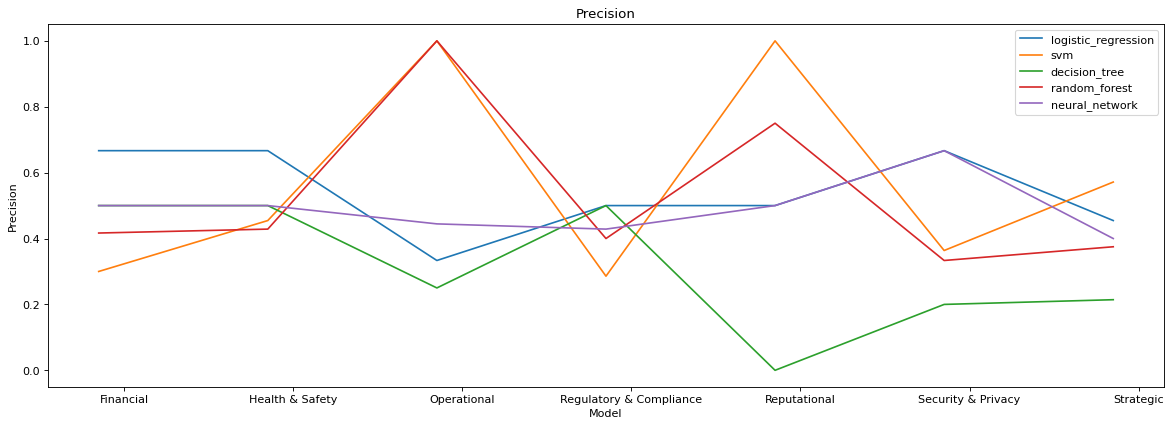

<Figure size 432x288 with 0 Axes>

In [59]:
plot_scores('Precision', category_scores, attrgetter('precision'), 'category-precision.png', fig_num=1)

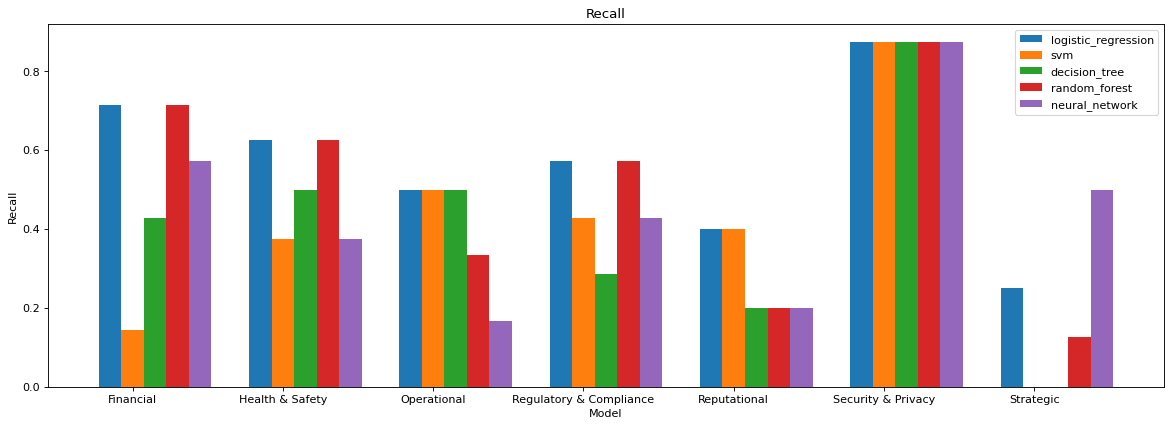

<Figure size 432x288 with 0 Axes>

In [24]:
plot_scores('Recall', category_scores, attrgetter('recall'), 'category-recall.png',fig_num=2)

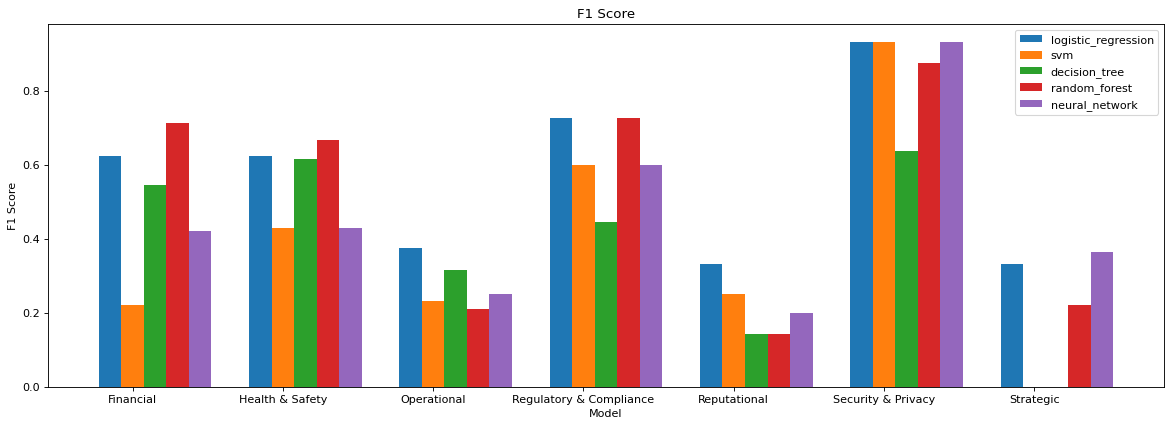

<Figure size 432x288 with 0 Axes>

In [25]:
plot_scores('F1 Score', category_scores, attrgetter('f1score'), 'category-f1_score.png', fig_num=3)

In [ ]:
process_df = pandas.read_excel(
    "~/Development/School/Data/risk-processes.xlsx"
)
task_df = pandas.read_excel(
    "~/Development/School/Data/tasks.xlsx"
)
task_df_grouped = task_df.groupby("Process")
task_df_grouped
# process_df["tasks"] = process_df.aply()
# risk_df = df[:]
# risk_df[""]

In [ ]:


#df[["Likelihood"]] = np.random.randint(1, 100, size=df[["Likelihood"]].shape)
df[["Impact"]] = np.random.randint(1, 100, size=df[["Impact"]].shape)
# attributes = df.drop("Category", 1)  # Feature Matrix
# classes = df["Category"]
# plt.figure()
cor = df.corr()
# print(cor)
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)

# print(df)

plt.show()